In [1]:
import json
import re
from textblob import TextBlob
from creds import connect

In [2]:
#Cleaning html tags from posts
def cleanhtml(raw):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw)
    return cleantext

In [3]:
#Cleaning pin tags from posts
def cleanpin(raw):
    cleantext = re.sub('#pin','',raw)
    return cleantext

In [24]:
#Cleaning raw data and outputing post contents to a json file
db = connect.mongo_database('edx')
raw = list(db['piazza'].find())
for course in raw:
    print(course.keys())

dict_keys(['_id', 'name', 'term', 'num', 'nid', 'is_ta', 'posts', 'users'])
dict_keys(['_id', 'name', 'term', 'num', 'nid', 'is_ta', 'posts', 'users'])
dict_keys(['_id', 'name', 'term', 'num', 'nid', 'is_ta', 'posts', 'users'])


In [30]:
for course in raw:
    print(f"Course: {course['num']} Term: {course['term']}\n\tPosts: {len(course['posts'])}")

Course: Verified MM Learners ISYE- 6501 Term: Fall 2018
	Posts: 448
Course: ISYE- 6501-OAN Term: Fall 2018
	Posts: 1695
Course: ISYE- 6501-OAN Term: Spring 2019
	Posts: 2550


In [44]:
"""
Since we are not sure if homeworks or exams changed, let's select a single course, Spring 2019,
which has the largest number of posts"
"""
post_list = raw[2]['posts']
output_dict = {}

for post in post_list:
    folders = post['folders']
    latest = post['history'][-1]
    raw_content = latest['content']
    cleaned_content = cleanpin(cleanhtml(raw_content.replace('\u00a0',' ').replace('\n',' '))).strip()
    for folder in folders:
        if folder not in output_dict:
            output_dict[folder] = [cleaned_content]
        else:
            output_dict[folder].append(cleaned_content)

In [45]:
#All the categories of posts 
output_dict.keys()

dict_keys(['logistics', 'other', 'hw15', 'exam', 'project', 'hw14', 'hw13', 'hw1', 'hw2', 'hw3', 'hw4', 'hw5', 'hw6', 'hw7', 'hw8', 'hw9', 'hw10', 'hw11', 'hw12', 'polls'])

In [46]:
#Simple NLP analysis on cleaned post content
#NLP analysis
avg_sentiment = {}
individual_sentiment = {}
neg_sentiment = {}
for i in output_dict:
    avg_sentiment[i] = 0
    individual_sentiment[i] = []
    content_list = output_dict[i]
    neg_sentiment[i] = []
    count = 0
    for j in content_list:
        x = TextBlob(j)
        avg_sentiment[i] += x.sentiment.polarity
        count += 1
        individual_sentiment[i].append(x.sentiment.polarity)
        if x.sentiment.polarity < 0:
            neg_sentiment[i].append(j)
    avg_sentiment[i] = avg_sentiment[i]/count
post_count = {i:len(individual_sentiment[i]) for i in individual_sentiment}
neg_post_count = {i:len(neg_sentiment[i]) for i in neg_sentiment}
#outputing negative post contents to a json file
#json.dump(neg_sentiment,open('neg_post_content.json','w'))

In [47]:
#Average sentiment by category
avg_sentiment

{'logistics': 0.12210712277457489,
 'other': 0.12484085419365132,
 'hw15': 0.1033016334823432,
 'exam': 0.09299436090326797,
 'project': 0.12348214337752952,
 'hw14': 0.12902841068205503,
 'hw13': 0.06879462939532922,
 'hw1': 0.08081584135373183,
 'hw2': 0.1161636496277041,
 'hw3': 0.05017137484679382,
 'hw4': 0.032301424211090786,
 'hw5': 0.052202211847233726,
 'hw6': 0.10584187070320186,
 'hw7': 0.06768816479395011,
 'hw8': 0.0877693491045346,
 'hw9': 0.08735610182449995,
 'hw10': 0.04971865478403616,
 'hw11': 0.0619226183656086,
 'hw12': 0.10057301697668777,
 'polls': 0.23666666666666666}

In [48]:
#Sentiments of each post by category 
individual_sentiment

{'logistics': [0.15714285714285717,
  0.21400000000000002,
  0.08454545454545455,
  0.0657967032967033,
  0.3228260869565217,
  -0.041666666666666664,
  0.018130630630630633,
  0.0,
  0.21914983164983168,
  0.1470430107526882,
  0.22499999999999998,
  0.0,
  0.14285714285714285,
  0.0,
  0.0,
  0.11666666666666665,
  -0.2333333333333333,
  0.04,
  0.0,
  0.25,
  -0.2708333333333333,
  0.16428571428571428,
  0.0,
  0.10205357142857142,
  -0.07142857142857144,
  0.25,
  0.06250000000000001,
  0.32564102564102565,
  0.09832015810276681,
  0.10357142857142856,
  0.0,
  -0.08,
  0.2589285714285714,
  0.15584415584415584,
  0.1708333333333333,
  0.08030303030303029,
  0.128125,
  0.09133522727272728,
  0.175,
  0.2,
  0.1,
  0.0,
  0.014285714285714282,
  0.14010416666666667,
  0.06000000000000001,
  0.325,
  -0.3,
  0.057154882154882146,
  -0.003787878787878788,
  0.375,
  0.0,
  0.31,
  0.07424242424242423,
  0.0,
  0.12916666666666665,
  0.019333333333333348,
  0.0,
  0.0875,
  0.2,
  0.0

In [51]:
#All post contents with negative sentiment by category
neg_sentiment['exam'][1]

'I failed to hit the submit button for my last few answer, but I had saved it. It is possible to submit those answer? How will it affect the grades?  Thanks.'

In [52]:
#Number of posts by category
post_count

{'logistics': 227,
 'other': 358,
 'hw15': 45,
 'exam': 445,
 'project': 103,
 'hw14': 46,
 'hw13': 116,
 'hw1': 282,
 'hw2': 200,
 'hw3': 163,
 'hw4': 131,
 'hw5': 103,
 'hw6': 128,
 'hw7': 106,
 'hw8': 101,
 'hw9': 127,
 'hw10': 87,
 'hw11': 14,
 'hw12': 89,
 'polls': 3}

In [53]:
#Number of negative posts by category
neg_post_count

{'logistics': 29,
 'other': 63,
 'hw15': 6,
 'exam': 92,
 'project': 15,
 'hw14': 4,
 'hw13': 27,
 'hw1': 70,
 'hw2': 31,
 'hw3': 45,
 'hw4': 43,
 'hw5': 30,
 'hw6': 26,
 'hw7': 29,
 'hw8': 22,
 'hw9': 26,
 'hw10': 32,
 'hw11': 3,
 'hw12': 15,
 'polls': 0}

In [57]:
import matplotlib.pyplot as plt

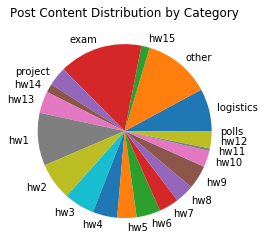

In [58]:
plt.pie(post_count.values(), labels = post_count.keys())
plt.title('Post Content Distribution by Category')
plt.show()

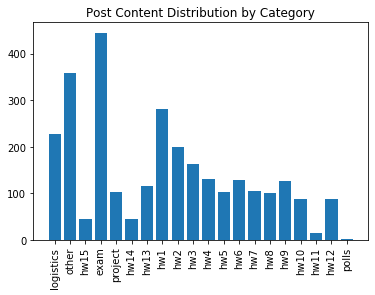

In [70]:
plt.bar(post_count.keys(), post_count.values())
plt.title('Post Content Distribution by Category')
plt.xticks(rotation=90)
plt.show()

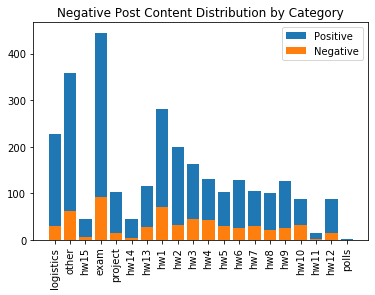

In [68]:
plt.bar(post_count.keys(), post_count.values(), label='Positive')
plt.bar(neg_post_count.keys(), neg_post_count.values(), label='Negative')
plt.title('Negative Post Content Distribution by Category')
plt.xticks(rotation=90)
plt.legend()
plt.show()

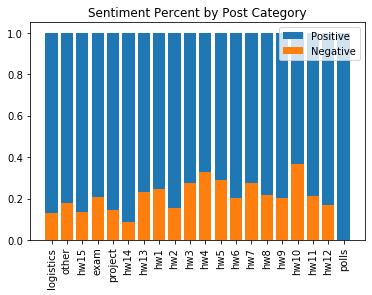

In [77]:
percent_neg = {}
for key in neg_post_count:
    percent_neg[key] = neg_post_count[key]/post_count[key]
plt.bar(percent_neg.keys(), [1]*len(percent_neg.keys()), label='Positive')
plt.bar(percent_neg.keys(), percent_neg.values(), label='Negative')
plt.title('Sentiment Percent by Post Category')
plt.xticks(rotation=90)
plt.legend()
plt.show()

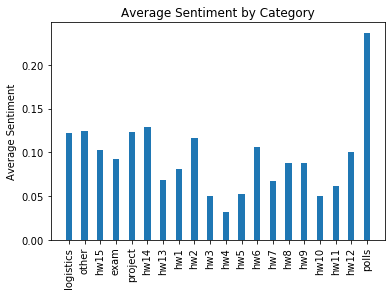

In [67]:
plt.bar(range(0, 2*len(avg_sentiment.values()),2),avg_sentiment.values())
plt.xticks(range(0, 2*len(avg_sentiment.values()),2), avg_sentiment.keys(), rotation = 'vertical')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Category')
plt.show()

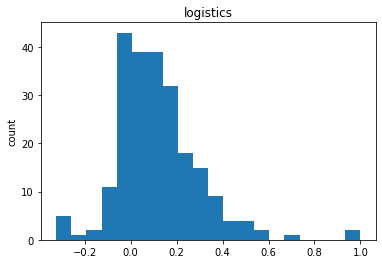

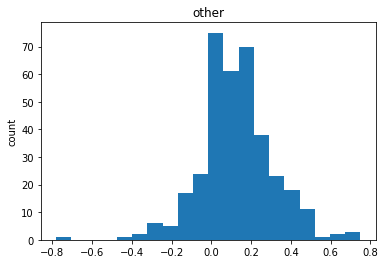

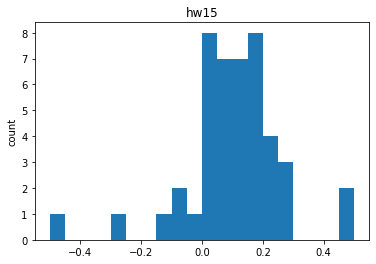

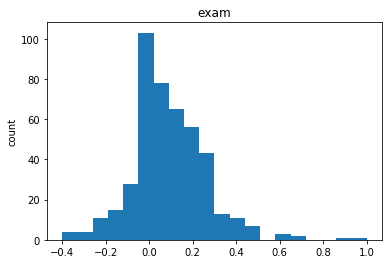

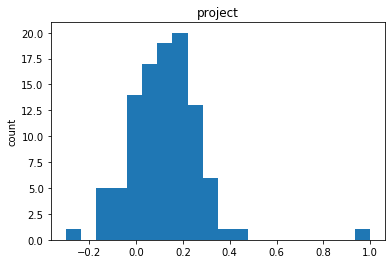

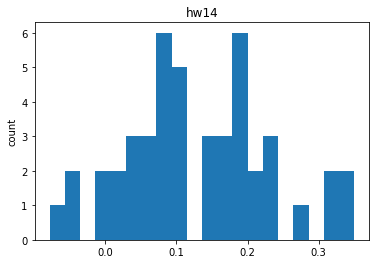

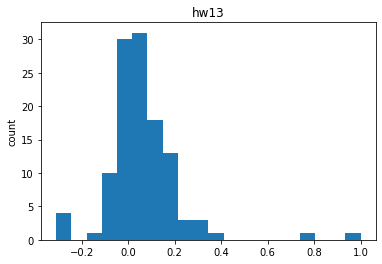

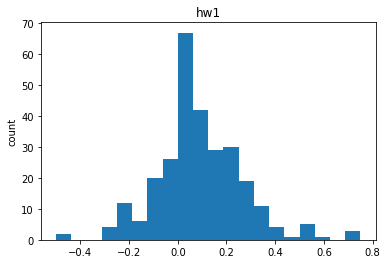

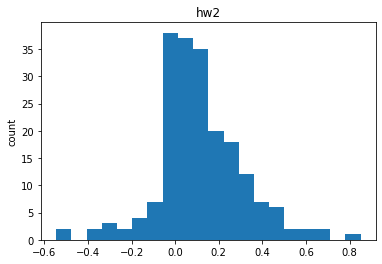

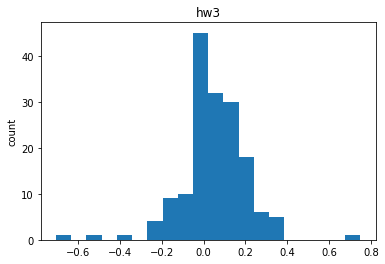

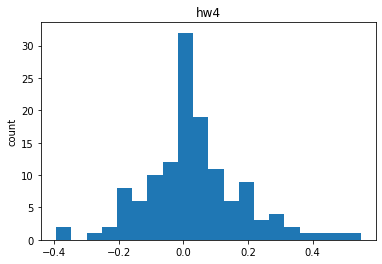

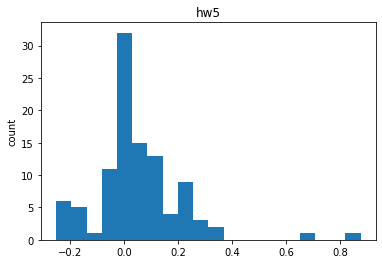

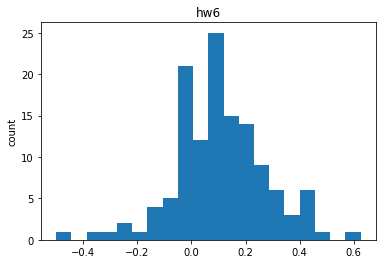

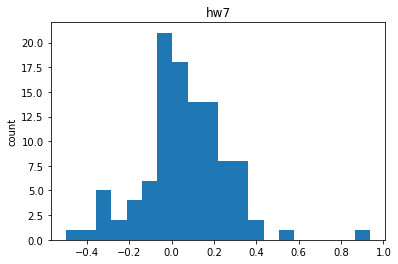

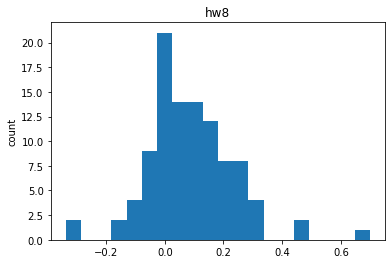

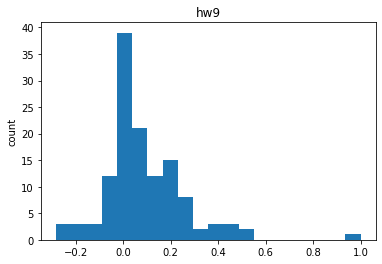

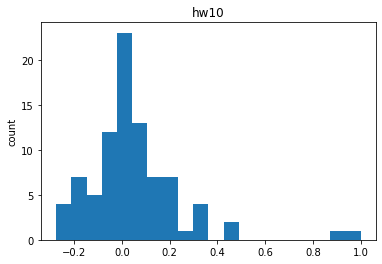

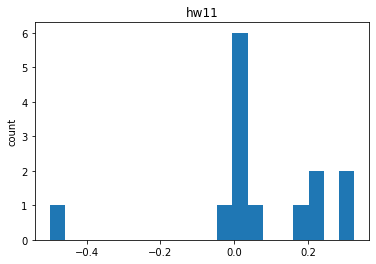

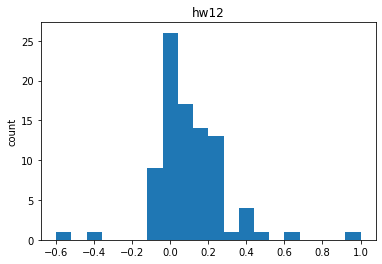

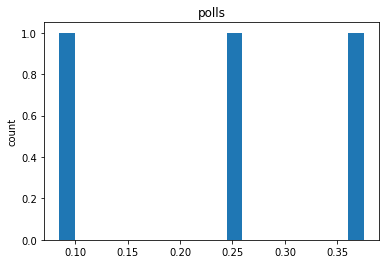

In [77]:
for i in individual_sentiment:
    sentiment_list = individual_sentiment[i]
    plt.hist(sentiment_list, bins = 20)
    plt.title(i)
    plt.ylabel('count')
    plt.show()

In [81]:
test.sentiment

Sentiment(polarity=0.1037408243929983, subjectivity=0.4830439488048184)

In [91]:
test= TextBlob('invisible')
test.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)